In [1]:
# A 165 LINE TOPOLOGY OPTIMIZATION CODE BY NIELS AAGE AND VILLADS EGEDE JOHANSEN, JANUARY 2013
from __future__ import division
import numpy as np
import math 
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Ken's function

def dim(arrayT): 
    dimensions = [len(arrayT), len(arrayT[0])]
    return dimensions 



# MAIN DRIVER
def main(nelx,nely,volfrac,penal,rmin,ft):

    # Max and min stiffness
    Emin=1e-9
    Emax=1.0
    # dofs:
    ndof = 2*(nelx+1)*(nely+1)
    # Allocate design variables (as array), initialize and allocate sens.
    x=volfrac * np.ones(nely*nelx,dtype=float)
    xold=x.copy()
    xPhys=x.copy()
    g=0 # must be initialized to use the NGuyen/Paulino OC approach
    dc=np.zeros((nely,nelx), dtype=float)
    # FE: Build the index vectors for the for coo matrix format.
    KE=lk()
    edofMat=np.zeros((nelx*nely,8),dtype=int)
    for elx in range(nelx):
        for ely in range(nely):
            el = ely+elx*nely
            n1=(nely+1)*elx+ely
            n2=(nely+1)*(elx+1)+ely
            edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])
    # Construct the index pointers for the coo format
    iK = np.kron(edofMat,np.ones((8,1))).flatten()
    jK = np.kron(edofMat,np.ones((1,8))).flatten()    
    # Filter: Build (and assemble) the index+data vectors for the coo matrix format
    nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
    iH = np.zeros(nfilter)
    jH = np.zeros(nfilter)
    sH = np.zeros(nfilter)
    cc=0


    # The additional changes should be done here 
    #------------------------------------------------------------------------------------------------------
    #GradMat= abs(direc(x))
    #maximum = max(max(GradMat)) 
    # rmin should be a matrix 

    #------------------------------------------------------------------------------------------------------
    for i in range(nelx):
        for j in range(nely):
            row=i*nely+j
            kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
            kk2=int(np.minimum(i+np.ceil(rmin),nelx))
            ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
            ll2=int(np.minimum(j+np.ceil(rmin),nely))
            for k in range(kk1,kk2):
                for l in range(ll1,ll2):
                    col=k*nely+l
                    fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
                    iH[cc]=row
                    jH[cc]=col
                    sH[cc]=np.maximum(0.0,fac)
                    cc=cc+1


    # Finalize assembly and convert to csc format
    H=coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc()	
    Hs=H.sum(1)
    # BC's and support
    dofs=np.arange(2*(nelx+1)*(nely+1))
    fixed=np.union1d(dofs[0:2*(nely+1):2],np.array([2*(nelx+1)*(nely+1)-1]))
    free=np.setdiff1d(dofs,fixed)
    # Solution and RHS vectors
    f=np.zeros((ndof,1))
    u=np.zeros((ndof,1))
    # Set load
    f[1,0]=-1
    # Initialize plot and plot the initial design
    plt.ion() # Ensure that redrawing is possible
    fig,ax = plt.subplots()
    im = ax.imshow(-xPhys.reshape((nelx,nely)).T, cmap='gray',\
    interpolation='none',norm=colors.Normalize(vmin=-1,vmax=0))
    fig.show()
   	# Set loop counter and gradient vectors 
    loop=0
    change=1
    dv = np.ones(nely*nelx)
    dc = np.ones(nely*nelx)
    ce = np.ones(nely*nelx)
    while change>0.01 and loop<2000:
        loop=loop+1
        # Setup and solve FE problem
        sK=((KE.flatten()[np.newaxis]).T*(Emin+(xPhys)**penal*(Emax-Emin))).flatten(order='F')
        K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()
        # Remove constrained dofs from matrix
        K = K[free,:][:,free]
        # Solve system 
        u[free,0]=spsolve(K,f[free,0])    
        # Objective and sensitivity
        ce[:] = (np.dot(u[edofMat].reshape(nelx*nely,8),KE) * u[edofMat].reshape(nelx*nely,8) ).sum(1)
        obj=( (Emin+xPhys**penal*(Emax-Emin))*ce ).sum()
        dc[:]=(-penal*xPhys**(penal-1)*(Emax-Emin))*ce
        dv[:] = np.ones(nely*nelx)
        # Sensitivity filtering:
        if ft==0:
            dc[:] = np.asarray((H*(x*dc))[np.newaxis].T/Hs)[:,0] / np.maximum(0.001,x)
        elif ft==1:
            dc[:] = np.asarray(H*(dc[np.newaxis].T/Hs))[:,0]
            dv[:] = np.asarray(H*(dv[np.newaxis].T/Hs))[:,0]
        # Optimality criteria
        xold[:]=x
        (x[:],g)=oc(nelx,nely,x,volfrac,dc,dv,g)
        # Filter design variables
        if ft==0:   xPhys[:]=x
        elif ft==1:	xPhys[:]=np.asarray(H*x[np.newaxis].T/Hs)[:,0]
        # Compute the change by the inf. norm
        change=np.linalg.norm(x.reshape(nelx*nely,1)-xold.reshape(nelx*nely,1),np.inf)
        # Plot to screen

        # The variable x 


        im.set_array(-xPhys.reshape((nelx,nely)).T)
        fig.canvas.draw()
        # Write iteration history to screen (req. Python 2.6 or newer)
    # Make sure the plot stays and that the shell remains	
    plt.show()
    input("Press any key...")
    return x 

#element stiffness matrix
def lk():
    E=1
    nu=0.3
    k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
    KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
    [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
    [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
    [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
    [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
    [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
    [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
    [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ])
    return (KE)
# Optimality criterion
def oc(nelx,nely,x,volfrac,dc,dv,g):
    l1=0
    l2=1e9
    move=0.2
    # reshape to perform vector operations
    xnew=np.zeros(nelx*nely)
    while (l2-l1)/(l1+l2)>1e-3:
        lmid=0.5*(l2+l1)
        xnew[:]= np.maximum(0.0,np.maximum(x-move,np.minimum(1.0,np.minimum(x+move,x*np.sqrt(-dc/dv/lmid)))))
        gt=g+np.sum((dv*(xnew-x)))
        if gt>0 :
            l1=lmid
        else:
            l2=lmid
    return (xnew,gt)


<ipython-input-1-4db7da9ca815>:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


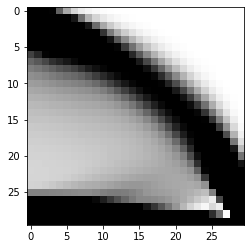

Press any key...


In [2]:
import numpy as np 
import csv

nelx=30
nely=30
volfrac=0.5
rmin=1
penal=1
ft=1 # ft==0 -> sens, ft==1 -> dens

densities = main(nelx,nely,volfrac,penal,rmin,ft).reshape((nelx,nely)).T

C:\Users\AdminSi\Anaconda3\envs\ML3DCAD\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=34,31 m=900 fp=0.003034 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


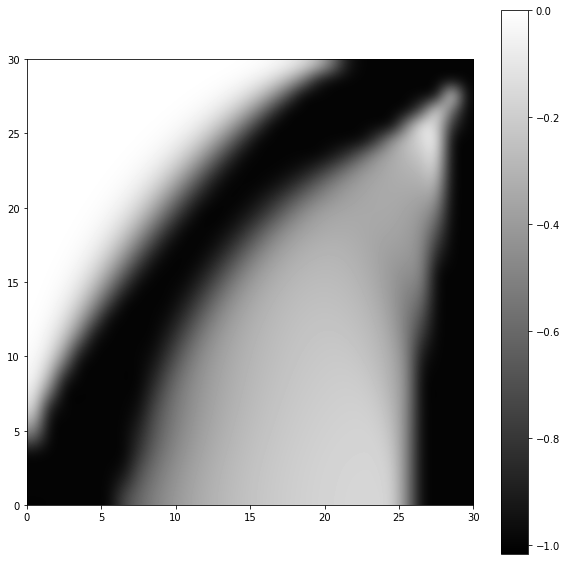

In [9]:
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

coord = np.array([[x, y] for x in range(nely) for y in range(nelx)])


x = coord[:,0]
y = coord[:,1]
f = interp2d(x,y,densities,kind="linear")

x_coords = np.arange(min(x),max(x)+1)
y_coords = np.arange(min(y),max(y)+1)
f_i = f(x_coords,y_coords)
fig = plt.figure(figsize=(10,10))
fig = plt.imshow(-f_i,
           extent=[min(x),max(x)+1,min(y),max(y)+1],
           origin="lower", interpolation='bicubic', cmap=cm.gray)


# Show the positions of the sample points, just to have some reference
fig.axes.set_autoscale_on(False)
plt.colorbar()
plt.show()
#plt.savefig('TopOpt.png')

(-2.55, 31.55, -1.55, 32.55)

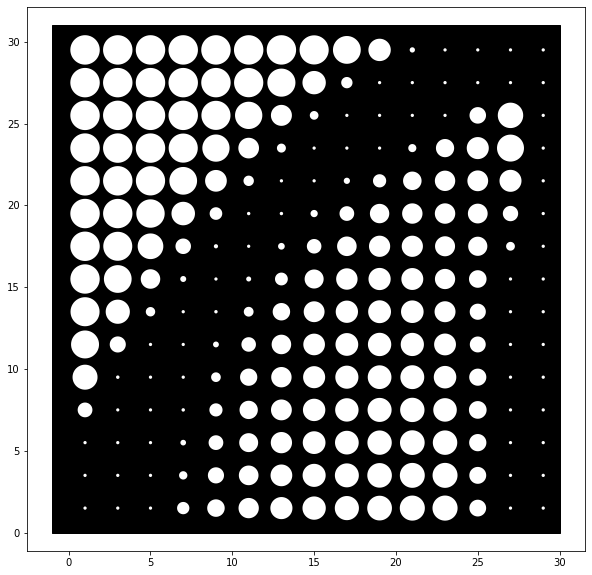

In [19]:
from numpy import sin, cos, sinh, cosh,arcsin,arccos, pi, exp, abs, max,min, sinh, cosh


def rhino_script(contour):

    with open('TopOpt.csv', 'w', newline='') as outfile:
        writer = csv.writer(outfile, delimiter=',', )
        # each collection is associated with a contour level    
        for collection in contour:
            # pline is an autocad command for polyline.  It interprets
            # the next (x,y) pairs as coordinates of a line until
            # it sees a blank line.
            writer.writerows(collection)
            outfile.write('\n')
                    


List_arrays = [] 
pt =np.array([[-1,0],[-1,nelx+1],[nely,nelx+1],[nely,0],[-1,0]])
List_arrays.append(np.array(pt))

def circles(): 
    for i in range(1,nely,2):
        for j in range(1,nelx,2):
            r= 2*(1-f(i,j))*(0.5-0.1)+0.1
            t= np.linspace(2*pi,0, 50)
            x=i+r*sin(t)
            y=j+0.5*(i%2)+r*cos(t)
            List_arrays.append(np.array([x.copy(),y.copy()]).T)
            #plt.plot(x,y, color ='k')
            axes.fill(x, y, "w") 
        

        
fig, axes = plt.subplots(figsize=(10,10)) #plt.figure(figsize=(10,10))
axes.fill(pt[:,0],pt[:,1], color ='k')
circles()



plt.axis('equal')
#rhino_script(List_arrays)